<a href="https://colab.research.google.com/github/lazyshyman/practice_place/blob/main/Ai_individual_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define device - using GPU if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the MNIST dataset with preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizing the data
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print("Data loaded and preprocessing applied.")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32194318.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1280802.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8481562.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2313642.07it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data loaded and preprocessing applied.


In [5]:
# Step 2: Define Models with Different Number of Layers
def create_model(num_layers):
    layers = []
    input_size = 28 * 28
    hidden_size = 128
    output_size = 10

    # Input layer
    layers.append(nn.Linear(input_size, hidden_size))
    layers.append(nn.ReLU())

    # Hidden layers
    for _ in range(num_layers):#'-'의 뜻은 루프 본문에 변수가 사용이 되지 않는다는 소리 그냥 num_layers만큼 반복은 하는데 for문에서 쓰이는 변수는 없음
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(nn.ReLU())

    # Output layer
    layers.append(nn.Linear(hidden_size, output_size))

    return nn.Sequential(*layers)#이 메소드는 각 레이어를 주면 그것을 합친 네트워크를 만들어줌 여기서 '*'의 의미는 압축해제 연산자로 list or tuple의 목록을 압축 해제해서 넣는다는 뜻인듯

In [8]:
# Step 3: Train and Evaluate Models
def train_and_evaluate(model, train_loader, test_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()#보통 Loss함수는 높을수록 해당 model이 안 좋다는 것을 의미, 이 메소드는 내부적으로 softmax함수가 포함
    optimizer = optim.Adam(model.parameters(), lr=0.001)#model.parameters()는 각 model의 매개변수(weight, bias 등)이 포함된 반복자를 반환

    # Training loop
    model.train()#model.train()을 하게 되면 model 훈련모드에 들어갔다는 걸 pytorch에게 알려주어 드롭아웃 및 배치정규화를 훈련중에 실행한다. 그리고 gradient 계산을 실행하는데 역전파를 이용해서 함
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.view(-1, 28 * 28).to(device)#view()함수는 데이터를 변경하지 않고 tensor를 재형성하는 메소드. (배치_크기, 채널, 높이, 너비)이런 식의 인자를 받음, mnist는 아마 64, 1, 28, 28 이거일거임, -1은 pytorch한테 너가 알아서 데이터 세트 참고해서 설정하라는 의미 알아서 64설정했을거임, 결과적으로 텐서의 모양을 (batch_size, 784)인 matrix로 만들었을 거고 각 행은 하나의 이미지를 의미
            labels = labels.to(device)#pytorch에서는 모델 매개변수, 입력 데이터, 대상 라벨이 동일한 기기에 있어야 함, 아니면 오류 발생

            optimizer.zero_grad()#각 훈련 단계에서 새로운 기울기를 계산하기 전에 기울기를 재설정하는 메소드
            outputs = model(images)
            loss = criterion(outputs, labels)#교차 엔트로피 손실을 계산함
            loss.backward()#오차역전파를 이용하여 손실함수의 gradient를 계산
            optimizer.step()#계산된 기울기를 사용하여 모델 매개변수를 업데이트함

    # Evaluation
    model.eval()#eval()을 써서 평가모드에 들어가면 model의 dropout기능이 꺼져서 모든 뉴런을 다 씀
    all_labels = []
    all_preds = []
    all_preds_probs = []
    with torch.no_grad():#gradient가 매번 계산되지 않아 메모리 사용량이 줄어 test하는 데 계산속도 빨라짐
        for images, labels in test_loader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)#torch.max(input,dim)는 input 텐서의 지정된 차원에 따라 최대값을 반환한다. '_'는 최댓값이 들어가는 자리인데 최댓값은 필요없고 라벨의 인덱스만 필요하기 때문에 넣은거임
            all_labels.extend(labels.cpu().numpy())#all_labels.extend는 numpy배열을 all_labels list에 추가하는 것을 의미 numpy()는 tensor를 numpy로 바꾸어 다양한 평가지표 계산하기 편하게 하기 위해 사용
            all_preds.extend(predicted.cpu().numpy())
            all_preds_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # ROC Curve (One-vs-Rest for multi-class)#OvR기법 사용
    all_labels_one_hot = np.eye(10)[all_labels]#np.eye(N)는 N x N 크기의 단위 행렬을 생성
    all_preds_probs = np.array(all_preds_probs)
    fpr = dict() #fals positive rate ,dict()함수는 빈 딕셔너리를 만드는 함수
    tpr = dict() #true positive rate
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], all_preds_probs[:, i])#roc_curve(y_true, y_score)는 FPR, TPR계산하는 함수, [:, i]는 i번째 column에 대해 선택하는 것을 의미
        roc_auc[i] = auc(fpr[i], tpr[i])#auc 측정해서 area 값을 이따 plot에 보여줌
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='best')
    plt.show()

    return accuracy, conf_matrix, f1


Training model with 1 layers:


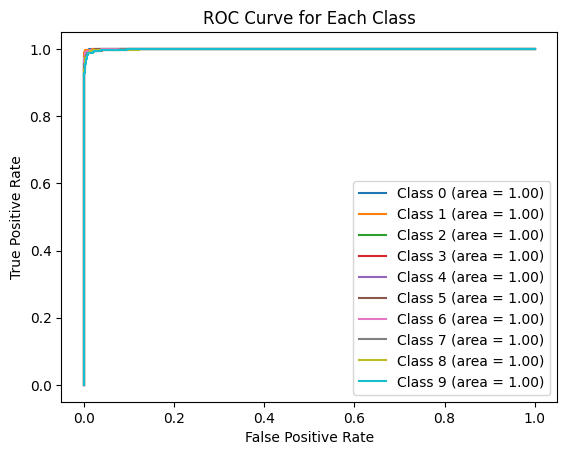

Accuracy: 0.9732
F1 Score: 0.9732
Confusion Matrix:
[[ 964    1    4    1    0    4    2    2    2    0]
 [   0 1126    1    3    0    0    3    0    2    0]
 [   1    4  982   21    2    0    0    6   15    1]
 [   0    0    4  986    0   11    0    2    2    5]
 [   1    0    2    0  958    0    5    1    0   15]
 [   2    0    0    8    1  869    4    0    4    4]
 [   3    3    2    1    3    4  940    0    2    0]
 [   2    8    8    2    2    0    0  987    0   19]
 [   0    2    1    9    4    2    3    2  942    9]
 [   2    2    0    3   17    4    0    3    0  978]]

Training model with 5 layers:


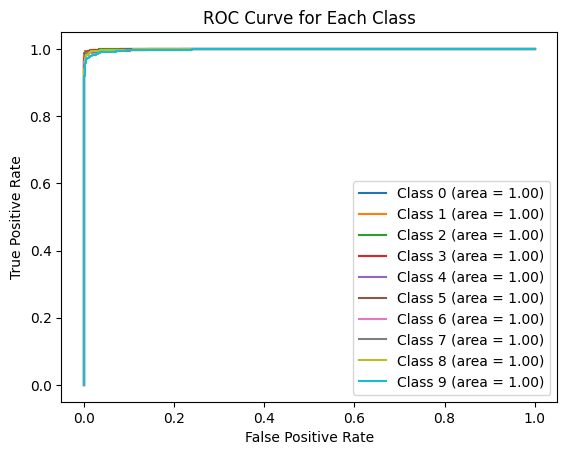

Accuracy: 0.9744
F1 Score: 0.9744
Confusion Matrix:
[[ 968    0    1    1    1    3    2    1    2    1]
 [   0 1119    1    0    0    2    3    0   10    0]
 [   3    2 1007    2    1    0    4    5    8    0]
 [   0    0    4  989    0    2    0    4    7    4]
 [   2    0    1    0  950    0   11    3    3   12]
 [   2    0    0   11    1  865    3    1    8    1]
 [   3    2    1    1    2    8  936    0    5    0]
 [   1   13   10    2    1    0    0  993    2    6]
 [   4    0    1    2    1    2    1    2  957    4]
 [   2    8    0    6    8    8    0    3   14  960]]

Training model with 10 layers:


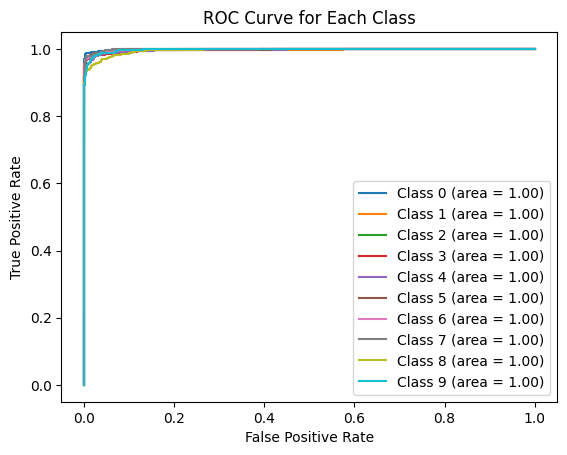

Accuracy: 0.9573
F1 Score: 0.9573
Confusion Matrix:
[[ 965    2    0    0    0    3    7    1    2    0]
 [   0 1074   15   17    0    1    2    1   23    2]
 [  10    0  996    4    3    1    5    9    4    0]
 [   2    0    5  977    0    9    1    9    7    0]
 [   2    0    1    0  916    1    8    2    4   48]
 [   3    0    2    9    0  868    5    1    3    1]
 [   6    1    2    0    5   13  927    0    4    0]
 [   1    6   10    4    0    0    0  995    2   10]
 [   4    2    4    4    8   38    3    3  901    7]
 [   4    1    0    9   10   12    0    9   10  954]]

Training model with 50 layers:


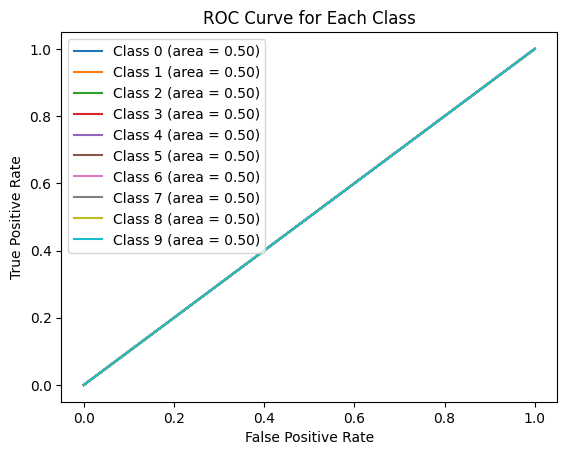

Accuracy: 0.1135
F1 Score: 0.0231
Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]

Training model with 100 layers:


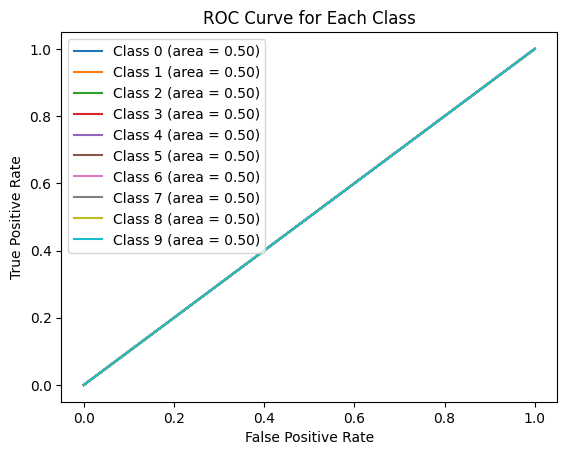

Accuracy: 0.1135
F1 Score: 0.0231
Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]


In [9]:
# Step 4: Experiment with Different Numbers of Layers
num_layers_list = [1, 5, 10, 50, 100]
results = {}

for num_layers in num_layers_list:
    print(f"\nTraining model with {num_layers} layers:")
    model = create_model(num_layers).to(device)
    accuracy, conf_matrix, f1 = train_and_evaluate(model, train_loader, test_loader)
    results[num_layers] = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'f1_score': f1
    }
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")


Training model with 5 layers and 5 epochs:


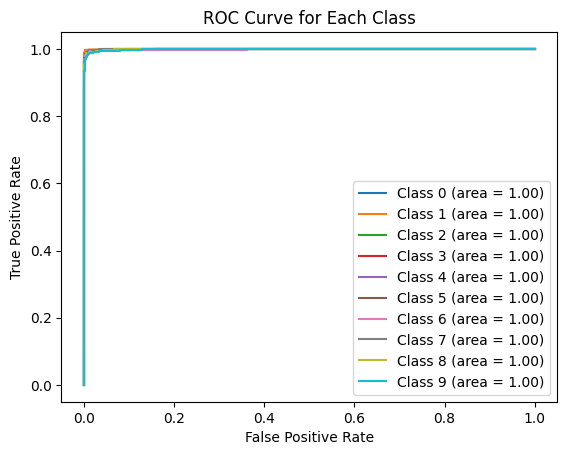

Accuracy: 0.9744
F1 Score: 0.9744
Confusion Matrix:
[[ 976    0    0    0    1    0    0    1    2    0]
 [   1 1125    1    3    0    0    0    2    3    0]
 [   7    4  987    6    1    0    0   22    5    0]
 [   1    0    1  996    0    2    0    6    3    1]
 [   2    1    4    0  965    0    4    1    0    5]
 [   8    0    1   14    1  856    5    2    3    2]
 [  11    5    1    0    7    3  926    0    5    0]
 [   2    5    5    0    1    0    0 1003    2   10]
 [   4    1    2    5    4    2    0    4  949    3]
 [   4    2    0    7   17    1    0    5   12  961]]

Training model with 5 layers and 10 epochs:


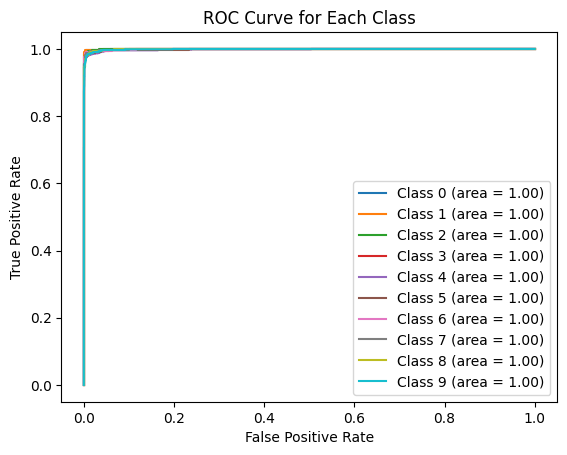

Accuracy: 0.9749
F1 Score: 0.9749
Confusion Matrix:
[[ 964    0    2    1    0    1    3    2    3    4]
 [   0 1128    3    0    0    1    1    1    1    0]
 [   1    1 1019    2    1    0    1    4    3    0]
 [   0    0    7  979    0   10    0    5    7    2]
 [   0    0    7    0  944    3    3    2    2   21]
 [   2    2    0    4    1  875    2    1    1    4]
 [   2    4    6    0    4    8  930    0    4    0]
 [   1    4   14    4    0    0    0  997    2    6]
 [   3    0   10   10    3   10    0    2  935    1]
 [   1    3    0    7    4    9    0    5    2  978]]

Training model with 5 layers and 50 epochs:


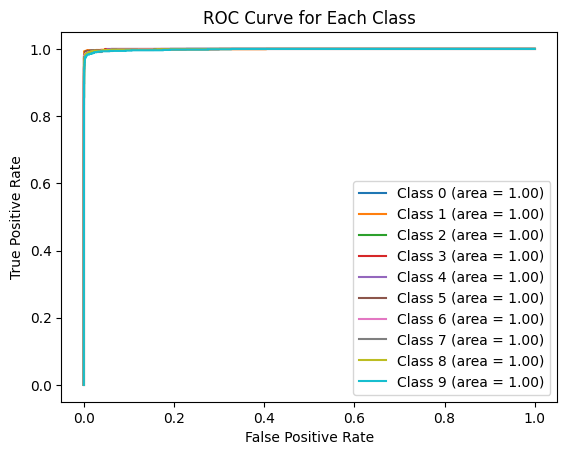

Accuracy: 0.9814
F1 Score: 0.9814
Confusion Matrix:
[[ 965    0    7    0    2    0    1    0    3    2]
 [   0 1125    0    3    0    2    2    0    2    1]
 [   1    2 1016    4    1    0    2    2    4    0]
 [   0    0    0  995    1    2    0    3    3    6]
 [   0    1    3    0  960    0    4    1    2   11]
 [   0    0    0    7    0  877    4    0    2    2]
 [   3    2    0    0    3    5  940    0    5    0]
 [   2    2    9    2    2    1    0  996    4   10]
 [   3    0    2    6    1    3    0    2  955    2]
 [   2    2    0    4    5    5    2    0    4  985]]


In [10]:
# Step 4: Experiment with Different Epochs
num_epochs_list = [5, 10, 50]
results = {}

for num_epochs in num_epochs_list:
    print(f"\nTraining model with 5 layers and {num_epochs} epochs:")
    model = create_model(5).to(device)
    accuracy, conf_matrix, f1 = train_and_evaluate(model, train_loader, test_loader, num_epochs=num_epochs)
    results[num_epochs] = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'f1_score': f1
    }
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

In [ ]:
# Step 4: Experiment with Different Optimizers
optimizers = {
    'SGD': lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    'Adagrad': lambda model: optim.Adagrad(model.parameters(), lr=0.001),
    'Adam': lambda model: optim.Adam(model.parameters(), lr=0.01)
}

results = {}
num_epochs = 10

for optimizer_name, optimizer_fn in optimizers.items():
    print(f"\nTraining model with 5 layers using {optimizer_name} optimizer for {num_epochs} epochs:")
    model = create_model(5).to(device)
    optimizer = optimizer_fn(model)
    accuracy, conf_matrix, f1 = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs=num_epochs)
    results[optimizer_name] = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'f1_score': f1
    }
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

이번엔 optimizer를 다르게 해서 test를 해본다.

In [11]:
# Step 3: Train and Evaluate Models
def train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs=5):
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_preds_probs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_preds_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # ROC Curve (One-vs-Rest for multi-class)
    all_labels_one_hot = np.eye(10)[all_labels]
    all_preds_probs = np.array(all_preds_probs)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], all_preds_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='best')
    plt.show()

    return accuracy, conf_matrix, f1


Training model with 5 layers using SGD optimizer for 10 epochs:


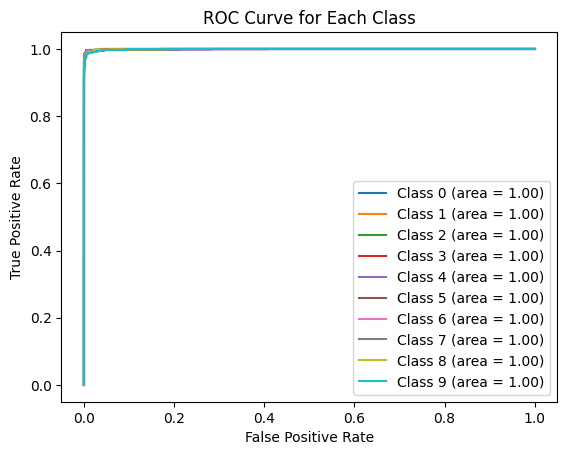

Accuracy: 0.9758
F1 Score: 0.9758
Confusion Matrix:
[[ 966    0    0    1    0    1    6    1    4    1]
 [   0 1107    6    1    0    0    2    4   15    0]
 [   4    0 1009    1    2    0    2    7    7    0]
 [   0    0    6  980    0    4    0    5   12    3]
 [   2    1    0    0  965    0    6    2    0    6]
 [   6    0    0    8    1  857    8    0    8    4]
 [   1    2    0    0    7    4  941    0    3    0]
 [   1    2   11    2    0    0    0 1002    3    7]
 [   1    0    4    3    1    2    1    3  957    2]
 [   5    2    0    2    9    3    1    3   10  974]]

Training model with 5 layers using Adagrad optimizer for 10 epochs:


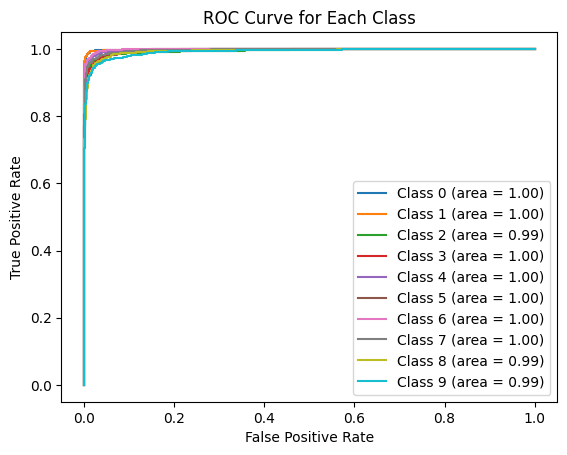

Accuracy: 0.9348
F1 Score: 0.9348
Confusion Matrix:
[[ 957    0    1    1    0   11    5    2    1    2]
 [   0 1107    4    2    1    4    1    1   14    1]
 [  10    6  948   17    8    4    9    4   24    2]
 [   0    1   21  935    0   15    0   14   19    5]
 [   2    1    3    0  929    0   10    0    3   34]
 [   9    2    5   29    3  797   12    0   26    9]
 [  12    3    4    0    8    7  919    0    5    0]
 [   2   15   12   10    2    0    0  944    0   43]
 [   3    3    5   11   13   24    8    5  894    8]
 [   9    5    1    7   38    8    1   14    8  918]]

Training model with 5 layers using Adam optimizer for 10 epochs:


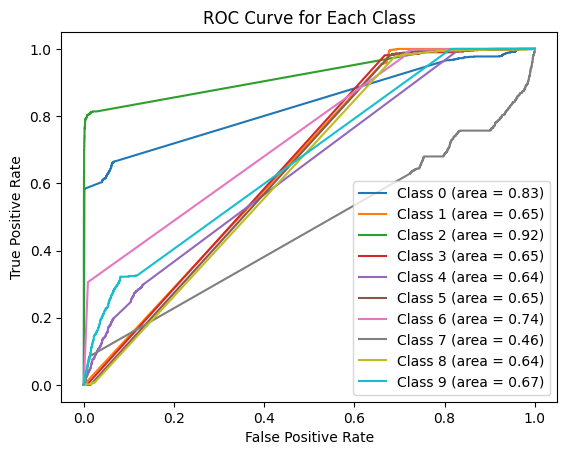

Accuracy: 0.3105
F1 Score: 0.2649
Confusion Matrix:
[[ 566  341    7    0    0    2   20    0   10   34]
 [   0 1116   19    0    0    0    0    0    0    0]
 [   0  207  821    0    0    0    2    0    0    2]
 [   0  995   12    0    0    0    0    0    0    3]
 [   4  695    0    0    4    0   46    0   19  214]
 [   2  879    2    0    0    0    7    0    0    2]
 [   2  658    4    0    0    0  293    0    1    0]
 [   0  583    3    0    0    0    0    0   25  417]
 [   2  950    5    0    0    0    7    0    2    8]
 [   0  688    0    0    0    0    0    0   18  303]]


In [12]:
# Step 4: Experiment with Different Optimizers
optimizers = {
    'SGD': lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    'Adagrad': lambda model: optim.Adagrad(model.parameters(), lr=0.001),
    'Adam': lambda model: optim.Adam(model.parameters(), lr=0.01)
}

results = {}
num_epochs = 10

for optimizer_name, optimizer_fn in optimizers.items():
    print(f"\nTraining model with 5 layers using {optimizer_name} optimizer for {num_epochs} epochs:")
    model = create_model(5).to(device)
    optimizer = optimizer_fn(model)
    accuracy, conf_matrix, f1 = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs=num_epochs)
    results[optimizer_name] = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'f1_score': f1
    }
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

이번엔 CNN으로 test해본다.

In [20]:
# Step 2: Define CNN Models with Different Number of Layers
def create_cnn_model(num_layers):
    layers = []
    input_channels = 1
    output_size = 10

    # Input convolutional layer
    layers.append(nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    # Additional convolutional layers
    in_channels = 32
    current_height = 28 // 2  # After first pooling
    for _ in range(num_layers):
        layers.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        if current_height > 2:  # Apply pooling only if the output size remains valid
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            current_height //= 2

    # Flatten layer
    layers.append(nn.Flatten())

    # Fully connected layer
    flattened_size = in_channels * current_height * current_height
    if flattened_size > 0:
        layers.append(nn.Linear(flattened_size, 128))
    else:
        raise ValueError("Flattened size is too small, adjust number of layers or pooling.")
    layers.append(nn.ReLU())
    layers.append(nn.Linear(128, output_size))

    return nn.Sequential(*layers)

In [21]:
# Step 3: Train and Evaluate Models
def train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs=5):
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_preds_probs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_preds_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # ROC Curve (One-vs-Rest for multi-class)
    all_labels_one_hot = np.eye(10)[all_labels]
    all_preds_probs = np.array(all_preds_probs)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], all_preds_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='best')
    plt.show()

    return accuracy, conf_matrix, f1


Training CNN model with 1 convolutional layers for 10 epochs:


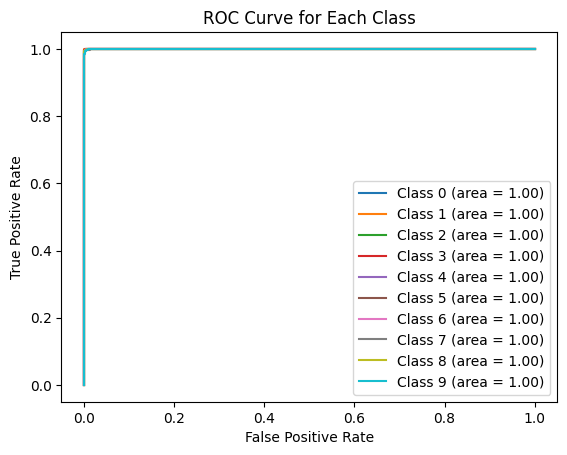

Accuracy: 0.9910
F1 Score: 0.9910
Confusion Matrix:
[[ 968    0    0    0    0    1    7    3    1    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [   0    0 1028    0    0    0    0    4    0    0]
 [   0    0    2 1000    0    4    0    1    3    0]
 [   0    0    1    0  972    0    1    0    1    7]
 [   1    0    0    5    0  877    7    0    0    2]
 [   1    2    0    0    2    0  952    0    1    0]
 [   0    0    9    0    0    0    0 1019    0    0]
 [   1    1    1    0    0    0    1    1  968    1]
 [   0    0    0    1    6    2    0    4    4  992]]

Training CNN model with 5 convolutional layers for 10 epochs:


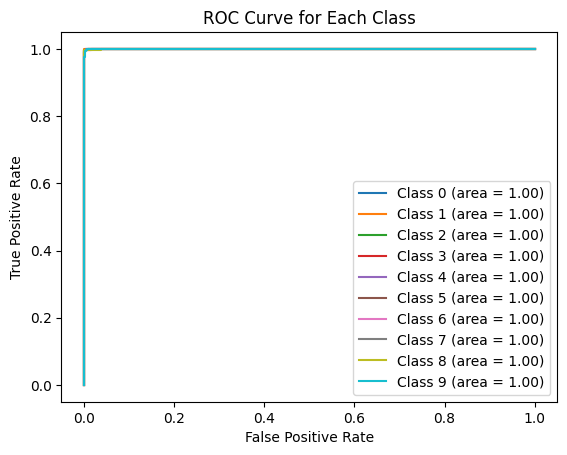

Accuracy: 0.9912
F1 Score: 0.9912
Confusion Matrix:
[[ 975    0    1    0    0    0    1    1    1    1]
 [   0 1129    0    0    1    1    1    2    1    0]
 [   1    0 1022    1    1    0    1    4    2    0]
 [   0    0    0 1004    0    5    0    0    0    1]
 [   0    0    0    0  966    0    1    2    0   13]
 [   2    0    0    1    0  887    1    0    0    1]
 [   2    2    1    0    1    6  945    0    1    0]
 [   0    0    5    1    1    0    0 1018    1    2]
 [   1    0    1    0    0    0    0    0  970    2]
 [   1    0    0    1    2    2    0    2    5  996]]

Training CNN model with 10 convolutional layers for 10 epochs:


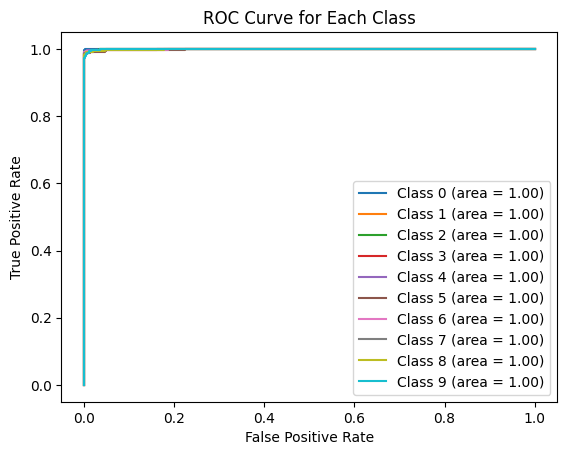

Accuracy: 0.9852
F1 Score: 0.9852
Confusion Matrix:
[[ 975    0    0    0    0    0    3    1    0    1]
 [   1 1108    6    0    2    0    3    0    3   12]
 [   1    1 1021    0    0    0    0    6    3    0]
 [   0    0    3  996    0    2    0    2    6    1]
 [   0    0    0    0  969    2    5    0    0    6]
 [   3    0    1    2    1  873    4    0    5    3]
 [   3    2    1    0    1    0  948    0    1    2]
 [   0    3    5    0    1    0    0 1014    1    4]
 [   0    0    1    7    0    1    0    0  960    5]
 [   0    0    0    0    5    1    0    5   10  988]]

Training CNN model with 30 convolutional layers for 10 epochs:


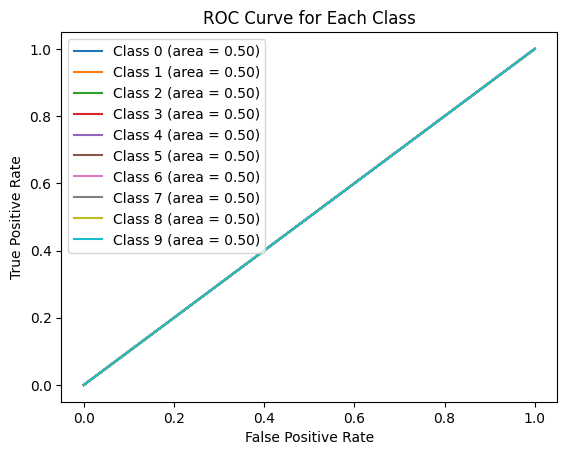

Accuracy: 0.1135
F1 Score: 0.0231
Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]


In [22]:
# Step 4: Experiment with Different CNN Layers
num_layers_list = [1, 5, 10, 30]
results = {}
num_epochs = 10

for num_layers in num_layers_list:
    print(f"\nTraining CNN model with {num_layers} convolutional layers for {num_epochs} epochs:")
    try:
        model = create_cnn_model(num_layers).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        accuracy, conf_matrix, f1 = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs=num_epochs)
        results[num_layers] = {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'f1_score': f1
        }
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")
    except ValueError as e:
        print(f"Error for model with {num_layers} layers: {e}")

이번엔 lr scheduler를 적용해보자

In [25]:
# Step 2: Define CNN Models with Different Number of Layers
class DebugCNNModel(nn.Module):
    def __init__(self, num_layers):
        super(DebugCNNModel, self).__init__()
        self.layers = nn.ModuleList()
        input_channels = 1
        output_size = 10

        # Input convolutional layer
        self.layers.append(nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Additional convolutional layers
        in_channels = 32
        current_height = 28 // 2  # After first pooling
        for _ in range(num_layers):
            self.layers.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
            self.layers.append(nn.ReLU())
            if current_height > 2:  # Apply pooling only if the output size remains valid
                self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                current_height //= 2

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        flattened_size = in_channels * current_height * current_height
        if flattened_size <= 0:
            raise ValueError("Flattened size is too small, adjust number of layers or pooling.")
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            print(f"Layer: {layer.__class__.__name__}, Output shape: {x.shape}")
        x = self.flatten(x)
        print(f"After Flatten, Output shape: {x.shape}")
        x = self.fc1(x)
        print(f"After FC1, Output value: {x}")
        x = self.relu(x)
        x = self.fc2(x)
        print(f"After FC2, Output value: {x}")
        return x


In [26]:
# Step 3: Train and Evaluate Models
def train_and_evaluate(model, train_loader, test_loader, optimizer, scheduler, num_epochs=5):
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Step the scheduler at the end of each epoch
        scheduler.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_preds_probs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_preds_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # ROC Curve (One-vs-Rest for multi-class)
    all_labels_one_hot = np.eye(10)[all_labels]
    all_preds_probs = np.array(all_preds_probs)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], all_preds_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='best')
    plt.show()

    return accuracy, conf_matrix, f1

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [-1.2858e+01, -2.8074e+00, -4.8611e+00,  7.1626e-01, -3.7061e+00,
         -3.7902e+00, -1.9643e+01,  7.4323e+00, -1.9811e-01,  6.1173e+00],
        [-5.6253e+00,  1.6980e+00,  6.5149e+00, -2.1326e+00, -8.5561e+00,
         -8.8417e+00, -7.3723e+00, -6.3936e+00,  1.3300e+00, -5.4945e+00],
        [-3.7241e+00,  2.7654e+00, -9.0923e-01, -1.2215e+01,  9.2630e+00,
         -6.9858e+00,  4.5708e+00, -1.1455e+01, -1.3262e+00, -2.5285e+00],
        [-7.9092e+00,  5.2170e+00,  8.2260e-01, -5.6879e+00,  1.1242e+00,
         -8.4562e+00, -5.1341e+00, -3.0856e+00, -2.3476e-01, -1.3461e+00],
        [-1.3151e+01, -2.4274e+00, -3.4532e+00,  1.6094e+00, -5.4417e+00,
         -4.4646e+00, -2.0217e+01,  7.3576e+00, -5.0162e-02,  4.9734e+00],
        [ 8.9921e+00, -1.0415e+01,  1.3712e+00, -3.8841e+00, -5.8446e+00,
          2.3389e+00,  5.4195e+00, -1.4054e+01,  2.5612e+00, -5.0345e+00],
        [ 5.0216e+00, -3.5948e+00,  2.3353e+00, -8.4260e+00,  4.7342e-

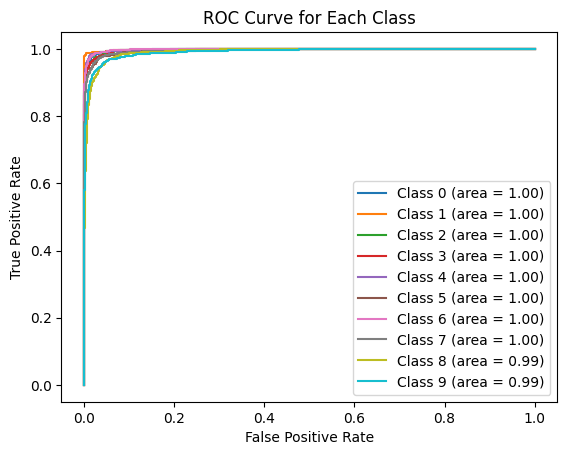

Accuracy: 0.9287
F1 Score: 0.9288
Confusion Matrix:
[[ 922    0    0    1    0   14   20    0   23    0]
 [   0 1115    7    2    1    0    1    0    8    1]
 [   6    2  969   19    1    2    5    8   20    0]
 [   0    0   13  947    0   11    0   16   21    2]
 [   0    5    1    0  936    0   14    0    3   23]
 [  12    0    0   16    0  813    0    1   44    6]
 [  34    3    1    0    4    4  904    0    8    0]
 [   0    7   15   12    0    0    0  921    6   67]
 [  16    2   15   19   16   13    7    8  849   29]
 [   2    4    0    5   25   15    1   25   21  911]]


In [27]:
# Step 4: Experiment with Different CNN Layers
num_layers_list = [5]
results = {}
num_epochs = 10

for num_layers in num_layers_list:
    print(f"\nTraining CNN model with {num_layers} convolutional layers for {num_epochs} epochs:")
    try:
        model = DebugCNNModel(num_layers).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce learning rate every 3 epochs
        accuracy, conf_matrix, f1 = train_and_evaluate(model, train_loader, test_loader, optimizer, scheduler, num_epochs=num_epochs)
        results[num_layers] = {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'f1_score': f1
        }
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")
    except ValueError as e:
        print(f"Error for model with {num_layers} layers: {e}")